In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
import tensorflow as tf

from ssd import SSD300
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
# some constants
NUM_CLASSES = 3
input_shape = (300, 300, 3)

In [3]:
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [4]:
from PASCAL_VOC.get_data_from_XML import XML_preprocessor
parsed_data = XML_preprocessor("data/annotation/")
gt = parsed_data.data
# gt = pickle.load(open('gt_pascal.pkl', 'rb'))
keys = sorted(gt.keys())
num_train = int(round(0.95 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)

unknown label: chair
unknown label: chair
unknown label: person
unknown label: person
unknown label: person
unknown label: person


In [5]:
gt

{'000050.jpg': array([[ 0.81      ,  0.408     ,  0.986     ,  0.68      ,  0.        ,
          0.        ],
        [ 0.55      ,  0.344     ,  0.624     ,  0.45333333,  0.        ,
          0.        ],
        [ 0.72      ,  0.512     ,  0.762     ,  0.70666667,  1.        ,
          0.        ],
        [ 0.798     ,  0.48266667,  0.844     ,  0.62666667,  1.        ,
          0.        ],
        [ 0.54      ,  0.48      ,  0.582     ,  0.65866667,  1.        ,
          0.        ],
        [ 0.588     ,  0.46933333,  0.624     ,  0.64266667,  1.        ,
          0.        ],
        [ 0.136     ,  0.256     ,  0.586     ,  1.        ,  0.        ,
          0.        ],
        [ 0.002     ,  0.18933333,  0.174     ,  0.88533333,  0.        ,
          0.        ],
        [ 0.37      ,  0.18133333,  0.518     ,  0.52533333,  0.        ,
          0.        ],
        [ 0.572     ,  0.17066667,  0.812     ,  0.63466667,  0.        ,
          0.        ]]),
 'bottle-00001

In [6]:
class Generator(object):
    def __init__(self, gt, bbox_util,
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size,
                 saturation_var=0.5,
                 brightness_var=0.5,
                 contrast_var=0.5,
                 lighting_std=0.5,
                 hflip_prob=0.5,
                 vflip_prob=0.5,
                 do_crop=True,
                 crop_area_range=[0.75, 1.0],
                 aspect_ratio_range=[3./4., 4./3.]):
        self.gt = gt
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.train_batches = len(train_keys)
        self.val_batches = len(val_keys)
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
        
    def grayscale(self, rgb):
        return rgb.dot([0.299, 0.587, 0.114])

    def saturation(self, rgb):
        gs = self.grayscale(rgb)
        alpha = 2 * np.random.random() * self.saturation_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
        return np.clip(rgb, 0, 255)

    def brightness(self, rgb):
        alpha = 2 * np.random.random() * self.brightness_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha
        return np.clip(rgb, 0, 255)

    def contrast(self, rgb):
        gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
        alpha = 2 * np.random.random() * self.contrast_var 
        alpha += 1 - self.contrast_var
        rgb = rgb * alpha + (1 - alpha) * gs
        return np.clip(rgb, 0, 255)

    def lighting(self, img):
        cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
        eigval, eigvec = np.linalg.eigh(cov)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigvec.dot(eigval * noise) * 255
        img += noise
        return np.clip(img, 0, 255)
    
    def horizontal_flip(self, img, y):
        if np.random.random() < self.hflip_prob:
            img = img[:, ::-1]
            y[:, [0, 2]] = 1 - y[:, [2, 0]]
        return img, y
    
    def vertical_flip(self, img, y):
        if np.random.random() < self.vflip_prob:
            img = img[::-1]
            y[:, [1, 3]] = 1 - y[:, [3, 1]]
        return img, y
    
    def random_sized_crop(self, img, targets):
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_area = img_w * img_h
        random_scale = np.random.random()
        random_scale *= (self.crop_area_range[1] -
                         self.crop_area_range[0])
        random_scale += self.crop_area_range[0]
        target_area = random_scale * img_area
        random_ratio = np.random.random()
        random_ratio *= (self.aspect_ratio_range[1] -
                         self.aspect_ratio_range[0])
        random_ratio += self.aspect_ratio_range[0]
        w = np.round(np.sqrt(target_area * random_ratio))     
        h = np.round(np.sqrt(target_area / random_ratio))
        if np.random.random() < 0.5:
            w, h = h, w
        w = min(w, img_w)
        w_rel = w / img_w
        w = int(w)
        h = min(h, img_h)
        h_rel = h / img_h
        h = int(h)
        x = np.random.random() * (img_w - w)
        x_rel = x / img_w
        x = int(x)
        y = np.random.random() * (img_h - h)
        y_rel = y / img_h
        y = int(y)
        img = img[y:y+h, x:x+w]
        new_targets = []
        for box in targets:
            cx = 0.5 * (box[0] + box[2])
            cy = 0.5 * (box[1] + box[3])
            if (x_rel < cx < x_rel + w_rel and
                y_rel < cy < y_rel + h_rel):
                xmin = (box[0] - x_rel) / w_rel
                ymin = (box[1] - y_rel) / h_rel
                xmax = (box[2] - x_rel) / w_rel
                ymax = (box[3] - y_rel) / h_rel
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(1, xmax)
                ymax = min(1, ymax)
                box[:4] = [xmin, ymin, xmax, ymax]
                new_targets.append(box)
        new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
        return img, new_targets
    
    def generate(self, train=True):
        while True:
            if train:
                shuffle(self.train_keys)
                keys = self.train_keys
            else:
                shuffle(self.val_keys)
                keys = self.val_keys
            inputs = []
            targets = []
            for key in keys:            
                if key.split('.')[-1] != 'jpg':
                    key += '.jpg'
                img_path = self.path_prefix + key
                img = imread(img_path).astype('float32')
                y = self.gt[key].copy()
                if train and self.do_crop:
                    img, y = self.random_sized_crop(img, y)
                img = imresize(img, self.image_size).astype('float32')
                if train:
                    shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    if self.vflip_prob > 0:
                        img, y = self.vertical_flip(img, y)
                y = self.bbox_util.assign_boxes(y)
                inputs.append(img)                
                targets.append(y)
                if len(targets) == self.batch_size:
                    tmp_inp = np.array(inputs)
                    tmp_targets = np.array(targets)
                    inputs = []
                    targets = []
                    yield preprocess_input(tmp_inp), tmp_targets
                  
        

In [7]:
path_prefix = 'VOCdevkit/VOC2007/JPEGImages/'
gen = Generator(gt, bbox_util, 9, path_prefix,
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), do_crop=False)

In [8]:
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('weights_SSD300.hdf5', by_name=True)

In [9]:
freeze = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
          'conv2_1', 'conv2_2', 'pool2',
          'conv3_1', 'conv3_2', 'conv3_3', 'pool3']#,
#           'conv4_1', 'conv4_2', 'conv4_3', 'pool4']

for L in model.layers:
    if L.name in freeze:
        L.trainable = False

In [10]:
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

callbacks = [keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                             verbose=1,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(schedule)]

In [11]:
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
# optim = keras.optimizers.RMSprop(lr=base_lr)
# optim = keras.optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss)

In [12]:
nb_epoch = 30
history = model.fit_generator(gen.generate(True), gen.train_batches,
                              nb_epoch, verbose=1,
                              callbacks=callbacks,
                              validation_data=gen.generate(False),
                              nb_val_samples=gen.val_batches,
                              nb_worker=1)

/home/nakamura/.pyenv/versions/anaconda3-4.0.0/envs/dynamic_fs/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
288/296 [============================>.] - ETA: 0s - loss: 3.2865

/home/nakamura/.pyenv/versions/anaconda3-4.0.0/envs/dynamic_fs/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: saving model to ./checkpoints/weights.00-2.98.hdf5
297/296 [==============================] - 23s - loss: 3.2762 - val_loss: 2.9788
Epoch 2/30
297/296 [==============================] - 22s - loss: 2.8291 - val_loss: 2.6039
Epoch 3/30
297/296 [==============================] - 20s - loss: 2.4754 - val_loss: 2.7788
Epoch 4/30
297/296 [==============================] - 23s - loss: 2.2553 - val_loss: 2.5240
Epoch 5/30
297/296 [==============================] - 22s - loss: 2.0499 - val_loss: 2.5440
Epoch 6/30
297/296 [==============================] - 22s - loss: 1.9444 - val_loss: 2.5095
Epoch 7/30
297/296 [==============================] - 22s - loss: 1.6994 - val_loss: 2.2800
Epoch 8/30
297/296 [==============================] - 22s - loss: 1.5953 - val_loss: 2.3813
Epoch 9/30
297/296 [==============================] - 20s - loss: 1.4671 - val_loss: 2.2815
Epoch 10/30
297/296 [==============================] - 22s - loss: 1.3158 - val_loss: 2.3419
Epoch 11/30
297/296 [=====

In [64]:
inputs = []
images = []
# img_path = path_prefix + sorted(val_keys)[-1]
for i in range(13, 16):
    img_path = path_prefix + sorted(train_keys)[i]
    img = image.load_img(img_path, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [65]:
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

1/3 [=========>....................] - ETA: 0s

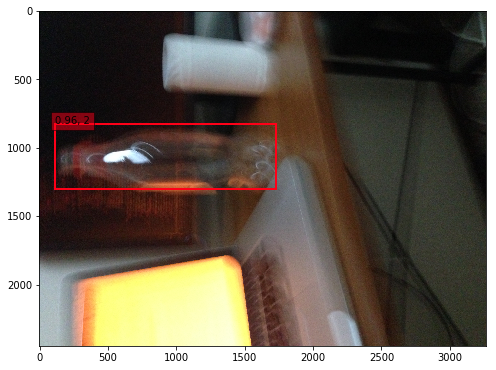

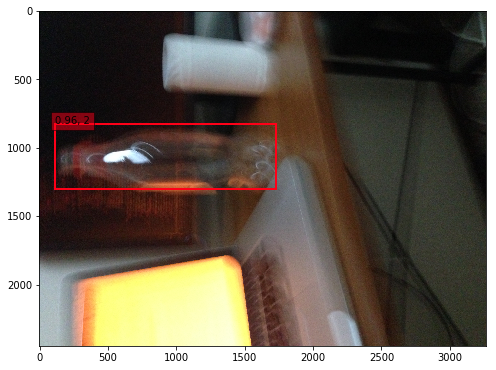

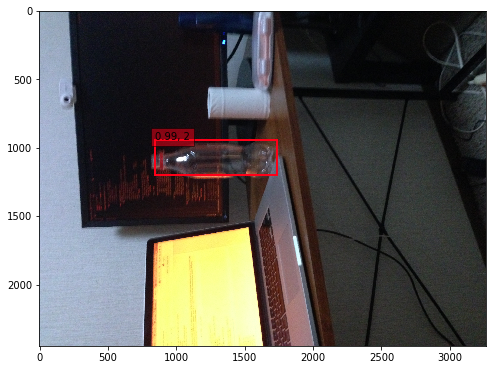

In [66]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]
#     top_indices = [i for i, label in enumerate(det_label) if label == 2]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 3)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
#         label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()

In [ ]:
def show_result(img, rectangles):
    